# Project of QF 625-Data Analysis with Python
***
# 0 Topic:  
## The Analysis of Premier Leauge Data over season 2006-07 to 2017-18

## 0.1 Data Description:
The dataset being used in the analysis is acquried from Kaggle( https://www.kaggle.com/zaeemnalla/premier-league). And the source of data comes from Premier League website. 

>**1.RANGE**: It covers various aspects of data from **seasons 2006/2007 to 2017/2018** which provides a long-term view to the leading league in Big Five.  

>**2.DETAIL**: There are two major kinds of data included in the dataset.    
>>2.1 DataFrame 'Result' is the **results of 4560 Premier League matches** - 380 matches over 12 seasons from 2006/2007 to 2017/2018. By using the result sheet, it is possible to get home-away relation, Victory/Defeated/Draw result and goals/losses in each match.   
>>2.2 Data frame 'Stats' is the details of the performance of each team in each season. This sub-dataset comprises of **240 rows of data from 20 clubs in 12 seasons**. There are 42 kinds of attributes as columns ranging from overview performance, such like total wins and goals, to some specific details such like goals from fastbreak, freekick and header.    
>>2.3 Due to the relagation and upgrade rules, the **presences of 20 clubs slightly changed during each season**.

>**3. FORMAT**: One of the advantages of the offical dataset is that it is **relatively clean**--no missing data among the entire description and all of them are arranged in good format saved as CSV.

>**4. Additional Web Scrapy**: However, there's still some data missing in the original sheet. We collect the data from web site and merge them by using BeautifulSoup.

## 0.2 Target

**1. From a view of overall performance**

>Classify these clubs by ranking and using some typical attributes. Try to find out if there are some common characteristics among them, we may get some clubs with same characteristics.    


**2. From a view of style and techniques**
>The raw data provides us various ways of goals(freekick, fastbreak, header...) and defence(tackle, interception, punch...), we may find out which of them is main contributors to points in the table. And these results may also reflect the inter-relationships between different attributes.

#  	1. Data wrangling

## 1.1 Packages Import and Load Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import requests 
import re
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from bs4 import BeautifulSoup as bs
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
import seaborn as sns
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/KavenWu/QF625-Group5Project/master/stats.csv"
url2 = "https://raw.githubusercontent.com/KavenWu/QF625-Group5Project/master/results.csv"
stats_seasons = pd.read_csv(url)
stats_seasons.sample()
results = pd.read_csv(url2)

In [3]:
stats_seasons.sample()

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
178,Burnley,7.0,19.0,28.0,64.0,2.0,430.0,125.0,13.0,8.0,...,783.0,171.0,21624.0,27.0,8.0,345.0,2.0,53.0,15.0,2014-2015


## 1.2 take a brief overview of data
>Before we start to analyze the data and try to find out some pattern within, it is necessary to have a overview from different aspects to it.   

>It is a good choice to begin with knowing what the columns and indices of the Data Frame include.

In [4]:
stats_seasons.columns

Index(['team', 'wins', 'losses', 'goals', 'total_yel_card', 'total_red_card',
       'total_scoring_att', 'ontarget_scoring_att', 'hit_woodwork',
       'att_hd_goal', 'att_pen_goal', 'att_freekick_goal', 'att_ibox_goal',
       'att_obox_goal', 'goal_fastbreak', 'total_offside', 'clean_sheet',
       'goals_conceded', 'saves', 'outfielder_block', 'interception',
       'total_tackle', 'last_man_tackle', 'total_clearance', 'head_clearance',
       'own_goals', 'penalty_conceded', 'pen_goals_conceded', 'total_pass',
       'total_through_ball', 'total_long_balls', 'backward_pass',
       'total_cross', 'corner_taken', 'touches', 'big_chance_missed',
       'clearance_off_line', 'dispossessed', 'penalty_save',
       'total_high_claim', 'punches', 'season'],
      dtype='object')

In [5]:
stats_seasons.shape

(240, 42)

>It seems that the data frame involves enormous amount of information, because there are **42 columns in each row**.   
>We can find some offence data such like *goals_on_target, goal_fastbreak, attack_penalties_goal, etc*, and also some defence data such like *total_tackle, total_clearance, etc*. Of course, it provides us the most important part--each team's wins and lossess in one season.

## 1.3 Additional Data from Web Scrapping

### Motivation

We can make a plenty of analysis with the existing data.

For example, if we want to find what contributes most to a goal, we investigate the total cross, corners and scoring number of every team. 

> However, there's still some data missing in the original sheet. We can collect from web site and merge them using techniques taught by professor.

> Unfortunately, the Premier League website has forbidden all our attempts to scrap data and always return an error403. So, we have to focus on adding more important missing variables from Yahoo sports to make our data analysis more plausible.

### This part is trying to add two main important yet missing variables to our data, they are:

#### Points 
> Points is one of the most important indicators of every team's performance. With data at hand, we can't count out the points directly.


#### Goal difference 
> GD is another vital indicator. Since we currently have the goals of every team, we can use it to count out the goals lost of every team, which is, again, an nonnegligible measurement of every team's defence.
 
Most data we wanted can only be found in a `drop down list`. So we have to apply certain methods to pretend a click with `webdriver` so that the target server can feed the needed imformation to us.

In [6]:
browser = webdriver.Chrome()

> Then it's the main part of scraping. Yahoo Sports only support data from 2013 to 2020, so we get them from the website and merge them back to our data after cleaning.
>> Despite trying countless time to extract the data we exactly want, I tried my best to keep the code neat and tidy;)

In [7]:
scrap = pd.DataFrame()
for a in range(2013,2020,1):
    url = "https://sports.yahoo.com/soccer/premier-league/standings/?season="+str(a)
    browser.get(url)
    html = browser.page_source
    html = bs(html,"lxml")
    df = pd.DataFrame()
    target = html.find("div", id ="Main")
    i = 0
    for r in target.find_all("span")[1:41]:
        if r.text != "":
            if r.text == "Bournemouth":
                df.loc[i,"team"]= "AFC Bournemouth"
                i+=1
                continue
            df.loc[i,"team"]= r.text
            i +=1 
    i = 0
    for r in target.find_all("td")[6:200:7]:
        if r.text != "":
            df.loc[i,"points"]= int(r.text)
            df.loc[i,"rank"] = int(i)+1
            i +=1 
    i = 0
    for r in target.find_all("td")[5:200:7]:
        if r.text != "":
            df.loc[i,"goal_difference"]= int(r.text)
            i +=1 
    df["season"] = str(a)+"-"+str(a+1)
    scrap = pd.concat([scrap,df])

In [8]:
datascrapped = pd.merge(stats_seasons,scrap,on = ["team","season"],how = "left")

# 2. Analysis

## 2.1 Points and Goal difference's effects overall

<ipython-input-9-83fbcfef705a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_win_loss["deuce"] = 38 - stat_win_loss["wins"] -stat_win_loss["losses"]
<ipython-input-9-83fbcfef705a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_win_loss["points"] = stat_win_loss["wins"]*3 + stat_win_loss["deuce"]*1
C:\Users\吴锴文\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

Text(0.5, 1.0, 'Average Points of each team in table')

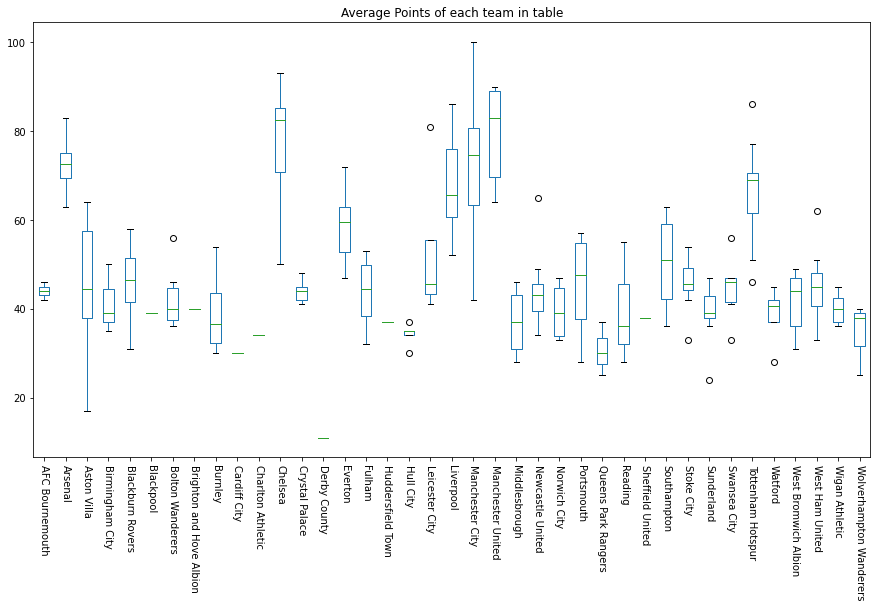

In [9]:
stat_win_loss = stats_seasons[["team","season", "wins", "losses"]]
stat_win_loss["deuce"] = 38 - stat_win_loss["wins"] -stat_win_loss["losses"]
stat_win_loss["points"] = stat_win_loss["wins"]*3 + stat_win_loss["deuce"]*1
points_season = stat_win_loss.pivot_table(index = "season", columns = "team", values = "points")
points_season.plot(kind = "box", figsize = (15, 8))
plt.xticks(rotation=270)
plt.title("Average Points of each team in table")

### There are several valuable reflections in the boxplot.

>**First**, amount top 7 best average points teams, **ManU** has the **best stability** as its range is mostly firmly close to the mean. On the countrary, **ManCity** has a widest range of points during 12 seasons among best 7, but the **highest points in an individual season**.

>**Second**, Those teams have a **medium level** of average performance also have **wider ranges or some **outliers(over 1.5 * IQR) in performance** such as *Aston Villa,Sunderland, Fulham, Portsmouth, etc*, for this reason, they **suffered delegation** in seasons showing by the outliers.

### Then, we want to find out how many `goal differences` are needed to be a champion. 
>Since this variable contains both scoring and conceding a goal, it can be a fitable indicator for a team's attack and defence. Hence, in the next part we will mainly focus on it.

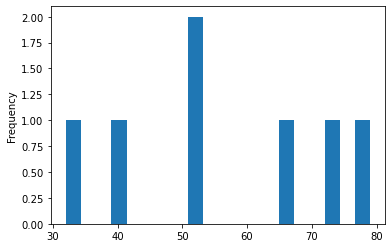

In [10]:
scrap[scrap["rank"]==1].goal_difference.plot(kind = "hist",bins = 20)

Above is a histogram showing the distribution of the goal difference that each year's champion has. 
>Let's next simply assmue they are `i.i.d` and follows a normal distribution. 

>Then we want to use the t-test to find the `confidence interval` of its mean. The answer will show at least how many goal differences are needed to win the championship.

>The distribution with 6 degree of freedom looks like bellow:

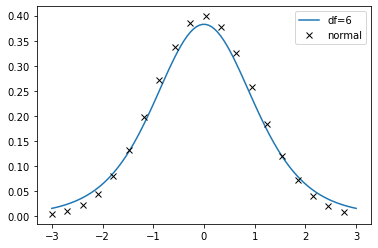

In [11]:
x = np.linspace( -3, 3, 100)
plt.plot(x, t.pdf(x,6), label = 'df=6')
plt.plot( x[::5], norm.pdf(x[::5]),'kx', label='normal')
plt.legend()
plt.show()

>Based on this, we will do the t-test and find out the 90% confidence interval

In [12]:
xmean=scrap[scrap["rank"]==1].goal_difference.mean()
xstd=scrap[scrap["rank"]==1].goal_difference.std(ddof=1)
interval= stats.t.interval(0.90,6,xmean,xstd)
x = np.linspace( -3, 3, 100)
print(interval)

(23.44525541477752, 88.84045887093677)


This interval shows if your team can't make your goal difference to be ***24*** or more, then you only have a tiny ***5%*** chance to win the cup.

## 2.2 The influence and Relations on Detail  
### A close examination of *Offence and Defence*  data helps to know the league better.
### 2.2.1 Data reconstruction

>First let's start with goal and lost, but lost is not listed in data frame directly, we have to produce it by calculating from other data.

In [13]:
home_lost = results.groupby(["home_team","season"])[["away_goals"]].sum()
home_lost.rename(columns = {'away_goals':'home_lost'}, inplace =True)
away_lost = results.groupby(["away_team","season"])[["home_goals"]].sum()
away_lost.rename(columns = {'home_goals':'away_lost'}, inplace =True)
#compute the total lost of each team in each season, by concatenate home lost and away lost
lost_season = pd.concat([home_lost, away_lost], axis = 1)
#compute the total lost of each team in each season by adding a new columns called lost
lost_season["lost"] = lost_season["home_lost"]+lost_season["away_lost"]
lost_season.reset_index(inplace = True)
lost_season.rename(columns = {'home_team':'team'},inplace = True)
lost_season

,team,season,home_lost,away_lost,lost
0,AFC Bournemouth,2015-2016,34.0,33.0,67.0
1,AFC Bournemouth,2016-2017,29.0,38.0,67.0
2,AFC Bournemouth,2017-2018,30.0,31.0,61.0
3,Arsenal,2006-2007,16.0,19.0,35.0
4,Arsenal,2007-2008,11.0,20.0,31.0
...,...,...,...,...,...
235,Wigan Athletic,2011-2012,27.0,35.0,62.0
236,Wigan Athletic,2012-2013,39.0,34.0,73.0
237,Wolverhampton Wanderers,2009-2010,22.0,34.0,56.0
238,Wolverhampton Wanderers,2010-2011,30.0,36.0,66.0


In [14]:
stats_seasons = pd.merge(stats_seasons, lost_season, how = "left")
stats_seasons = pd.merge(stats_seasons, stat_win_loss, how = "left")

### 2.2.2 Relationship among main indicators
### Create a new variable to present the goal/lost ratio
>find out which team has the best goal lost ratio.

In [15]:
stats_seasons["ratio_goal_lost"] = stats_seasons["goals"]/stats_seasons["lost"]
performance_cmpr_season = stats_seasons[["team","season","goals","lost","ratio_goal_lost","points"]]
average_cmpr = performance_cmpr_season.groupby("team").mean()
average_cmpr.head()

,goals,lost,ratio_goal_lost,points
team,,,,
AFC Bournemouth,48.333333,65.000000,0.743414,44.000000
Arsenal,71.750000,40.083333,1.818099,72.666667
Aston Villa,44.900000,55.400000,0.863057,45.600000
Birmingham City,40.333333,55.666667,0.729459,41.333333
Blackburn Rovers,46.166667,59.000000,0.801966,45.833333


### Check the relationship between points and goals

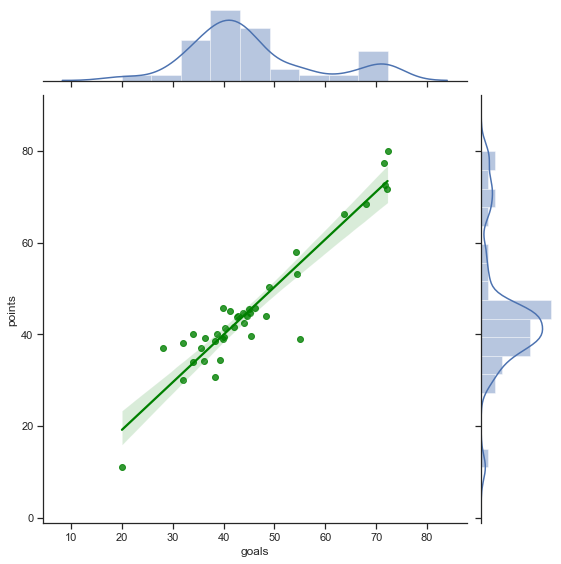

In [16]:
sns.set(style = "ticks")

sns.jointplot(y = average_cmpr.points,
              x = average_cmpr.goals,
              data = average_cmpr,
              kind = "reg",
              joint_kws = {"color": "green"},
              height = 8)

### Check the relationship between points and lost

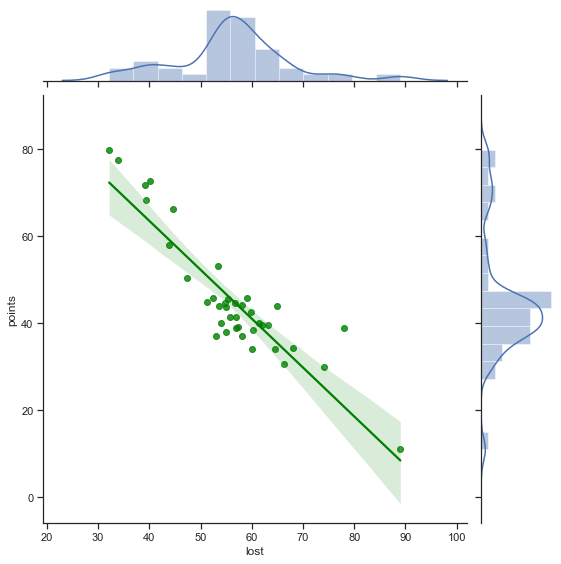

In [17]:
sns.set(style = "ticks")

sns.jointplot(y = average_cmpr.points,
              x = average_cmpr.lost,
              data = average_cmpr,
              kind = "reg",
              joint_kws = {"color": "green"},
              height = 8)

### Possibly ratio of goal to lose fits performance of teams better.

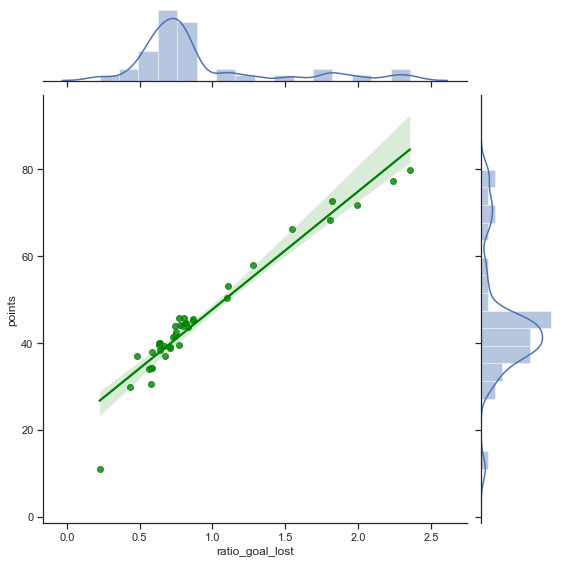

In [18]:
sns.set(style = "ticks")

sns.jointplot(y = average_cmpr.points,
              x = average_cmpr.ratio_goal_lost,
              data = average_cmpr,
              kind = "reg",
              joint_kws = {"color": "green"},
              height = 8)

### Conclusion on the relationships among points, goals, losts and goal-lost ratio:

>Goals and Goal-Lost Ratio have positive relationships with Average Performance which is presented by Points.


>Numbers of Losts is definitely negatively related with the Average Performance.

>We can see Goal-Lost Ratio fits better than Goals alone to the Points, especially presenting on those teams with higher points. Apparently, it suggests that a **well balance between Goals and lost control is the key to win.** 

### 2.2.3 Relationship of Performance among teams 
>Now, it's better to unfold the season and see relations between different teams.

In [19]:
performance_team_season = stats_seasons.pivot(index = "season", columns = "team",values = "points")
performance_team_season = performance_team_season.dropna(axis = 1)
performance_team_season.head(8)

team,Arsenal,Chelsea,Everton,Liverpool,Manchester City,Manchester United,Tottenham Hotspur
season,,,,,,,
2006-2007,68.0,83.0,58.0,68.0,42.0,89.0,60.0
2007-2008,83.0,85.0,65.0,76.0,55.0,87.0,46.0
2008-2009,72.0,83.0,63.0,86.0,50.0,90.0,51.0
2009-2010,75.0,86.0,61.0,63.0,67.0,85.0,70.0
2010-2011,68.0,71.0,54.0,58.0,71.0,80.0,62.0
2011-2012,70.0,64.0,56.0,52.0,89.0,89.0,69.0
2012-2013,73.0,75.0,63.0,61.0,78.0,89.0,72.0
2013-2014,79.0,82.0,72.0,84.0,86.0,64.0,69.0


### Then we start to make scatter in order to find out if there are any relations between the performance of teams.

In [20]:
#make a scatter plot function to facilitate visualization
def make_scatter_plot(data,
                      x_team_name,
                      y_team_name,
                      xlim = None,
                      ylim = None):
    
    fig = plt.figure(figsize = (10, 6))
    
    ax = fig.add_subplot(111)
    ax.scatter(data[x_team_name], data[y_team_name], alpha = 0.9)
    
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    ax.autoscale(False)
    
    ax.vlines(0, 0, 100, color = "grey")
    ax.hlines(0, 0, 100, color = "grey")
    
    ax.plot((0, 100), (0, 100), color = "red") # Perfect Correlation Benchmark :) for an Effective Comparison
    
    ax.set_xlabel(x_team_name)
    ax.set_ylabel(y_team_name)

Text(0.5, 1.0, 'NorthLondon-ManU Relations')

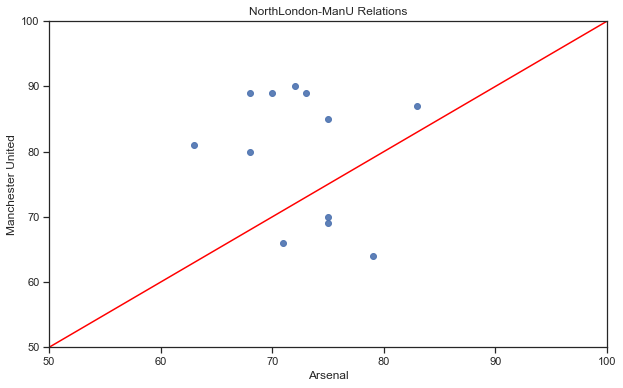

In [21]:
make_scatter_plot(performance_team_season, "Arsenal", "Manchester United", xlim = (50, 100), ylim = (50, 100))
plt.title("NorthLondon-ManU Relations")

### There is no obvious relationship of the performance among Chelsea, ManU and Arsenal in the view of Points by season.

>Since that, A matrix of comparison can help to have a comprehensive examination over the best 7. Perhaps we can obtain some valuable information from that.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016DB9E835B0>,
      dtype=object)

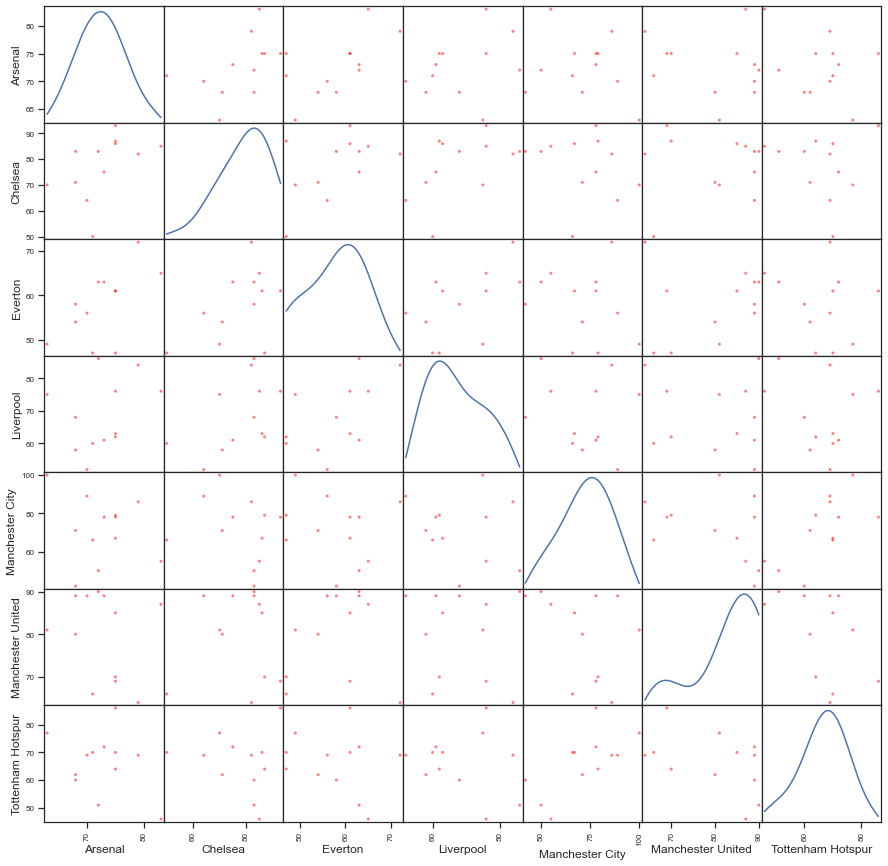

In [22]:
# pd.scatter_matrix() is deprecated :)

pd.plotting.scatter_matrix(performance_team_season, diagonal = "kde", alpha = 0.5, figsize = (15,15), color = "red")

## It seems we have a failure in trying to find out the relations between overall performance of teams.

>The reason behind could possiblely be that 12 seasons data is too less to produce any consequences or there is not actual relationship between them.

>It's a important lesson that we need large amount of samples to draw a statistic conclusion to satisify the Large Number Theorem. Now we can refuse or accept our hypothsis neither.

### Failure is the best teacher.
### It tells us we should take a deeper insight into the data which may convey some valuable information. 

>Let's try to find some common phenamenon among the different details given by stats information. 

>Starting from offence may give us some clue as we know goals have a strong relationship with performance.

### 2.2.4 Deeper insight into offence and defence attributes
### 2.2.4.a Offence Side

In [23]:
att_stats_season = stats_seasons[["team","season","points","goals","lost",'deuce',"ratio_goal_lost","total_scoring_att","ontarget_scoring_att","hit_woodwork",'att_hd_goal', 'att_pen_goal', 'att_freekick_goal',
       'att_ibox_goal', 'att_obox_goal', 'goal_fastbreak']]
#average statitics over 12 seasons
average_att_team = att_stats_season.groupby(["team"]).mean()
average_att_team.head()

,points,goals,lost,deuce,ratio_goal_lost,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,att_pen_goal,att_freekick_goal,att_ibox_goal,att_obox_goal,goal_fastbreak
team,,,,,,,,,,,,,,
AFC Bournemouth,44.000000,48.333333,65.000000,10.000000,0.743414,460.333333,153.666667,12.333333,6.666667,4.333333,0.333333,42.666667,6.000000,0.666667
Arsenal,72.666667,71.750000,40.083333,8.916667,1.818099,611.583333,221.000000,17.166667,11.916667,4.333333,1.500000,63.750000,8.083333,5.000000
Aston Villa,45.600000,44.900000,55.400000,11.700000,0.863057,456.100000,146.700000,10.100000,8.900000,3.600000,1.500000,36.500000,8.400000,4.100000
Birmingham City,41.333333,40.333333,55.666667,12.333333,0.729459,422.333333,139.666667,8.000000,6.333333,3.333333,3.000000,32.666667,7.666667,2.000000
Blackburn Rovers,45.833333,46.166667,59.000000,9.833333,0.801966,479.333333,154.500000,11.666667,10.833333,3.666667,1.500000,38.833333,7.333333,1.666667


### Let's first check out the relationship between shorts and points.

Text(0.5, 1.0, 'Relation between Points and Total Shots')

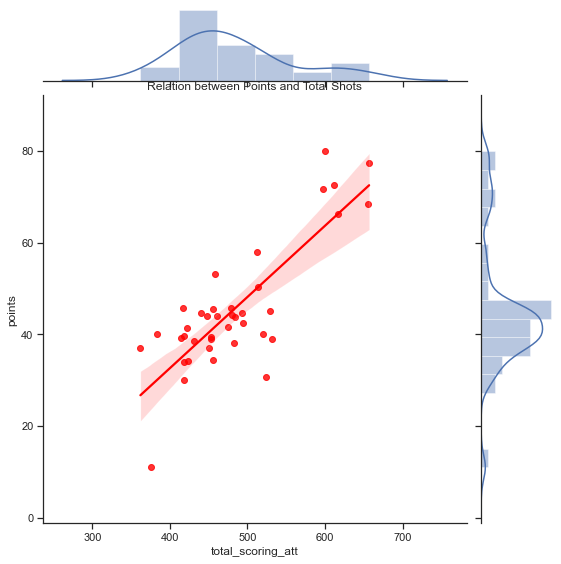

In [24]:
sns.set(style = "ticks")

sns.jointplot(y = average_att_team.points,
              x = average_att_team.total_scoring_att,
              data = average_cmpr,
              kind = "reg",
              joint_kws = {"color": "red"},
              height = 8)
plt.title("Relation between Points and Total Shots")

> From the diagram we can find that better usually teams have more shot attempts.

>But, for medium level teams within 60-30 points, more attempts of shots don't lead to success. More detaled, there are six teams got a average shots around 500, but their points range from 60 to 30. Two fold of points can be regarded as a very high significance.

### For the benefit of efficiency, we need a matrix to show all of relationships between attacking details and performance.

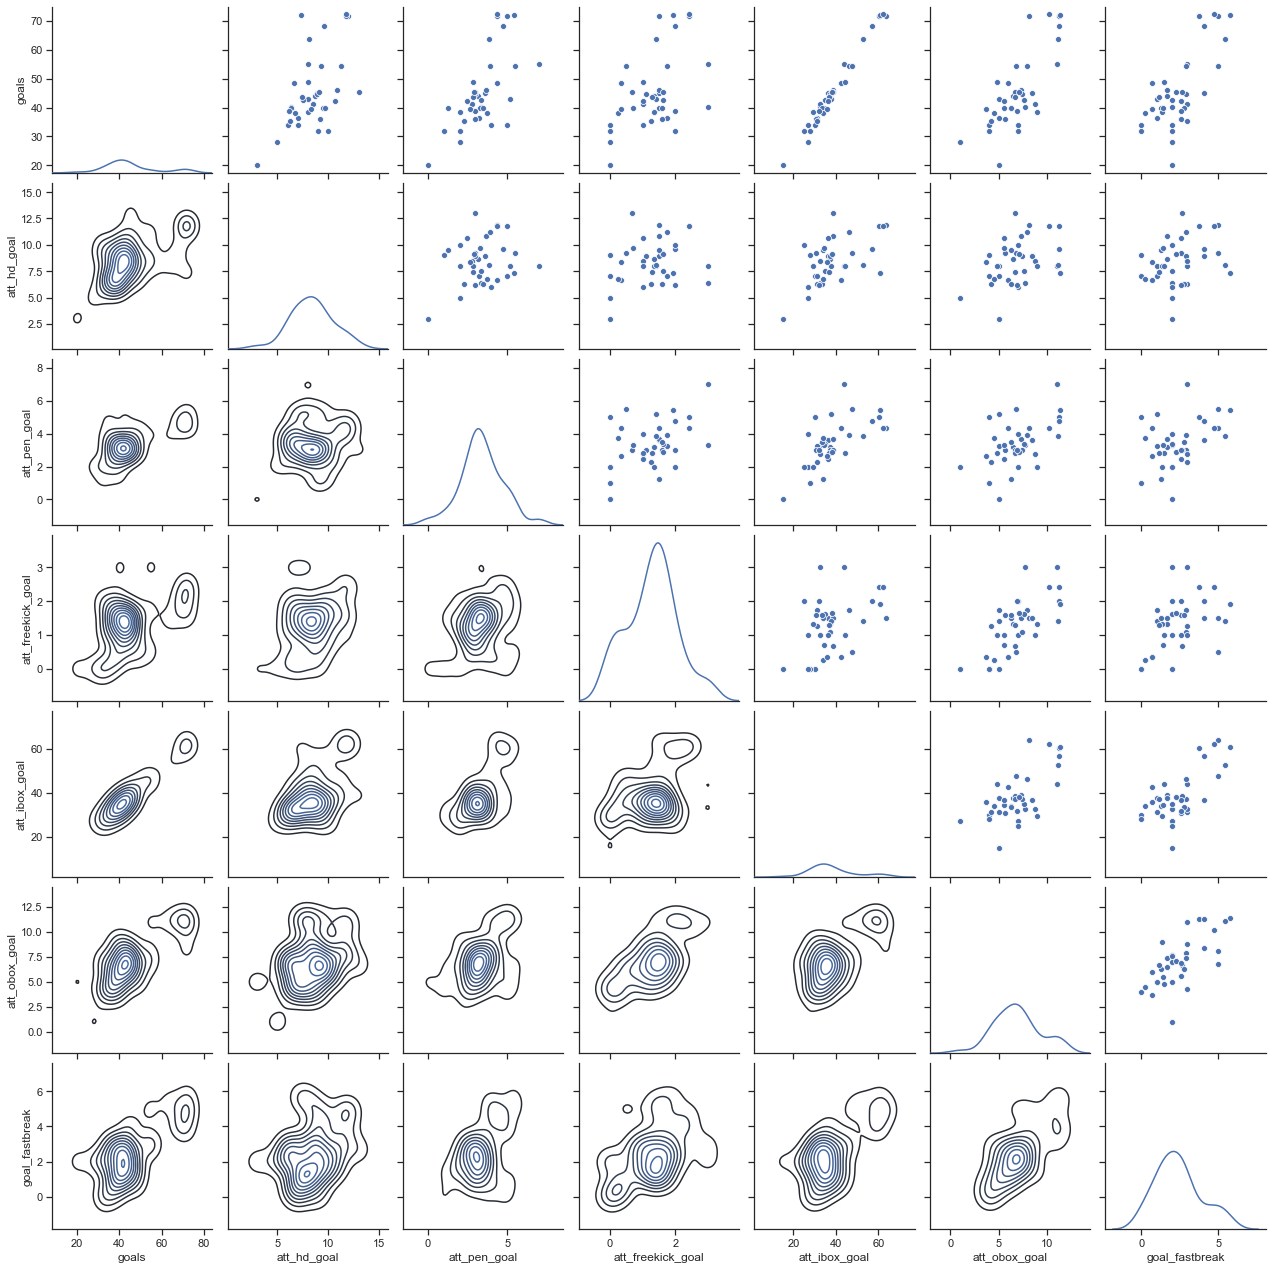

In [25]:
g = sns.PairGrid(average_att_team[["goals",'att_hd_goal', 'att_pen_goal', 'att_freekick_goal',
       'att_ibox_goal', 'att_obox_goal', 'goal_fastbreak']])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

### The matrix shows three important implications:

>First, attacks in penalty area presents a strong relations with goals which is far more tham out box attacks. It means if some team want to goal, make more chance in the penalty area.

>Seconds, best 7 are more competitive in fastbreak and out box goal. Medium level teams should pay special attention to their rivals' fastbreak and goal when matching with give 7.

>Third, freekick has the most condensed statistic and in-box goals has the least. It reflects that the abilities to get goal by freekick among differents teams are not pervasive. But ability of making in-box goal makes teams distingushing.

### 2.2.4.b Dffence Side
>Turn to defence performance. First, let's filter out related variables.

In [26]:
# select the columns needed for subsequent analysis
dfc_stats_season = stats_seasons[['team',"season","lost",'saves', 'outfielder_block', 'interception',
       'total_tackle', 'last_man_tackle', 'total_clearance', 'head_clearance',
       'own_goals','punches', "points"]]
average_dfc_team = dfc_stats_season.groupby(["team"]).mean()
#see what we have now
average_dfc_team.head()

,lost,saves,outfielder_block,interception,total_tackle,last_man_tackle,total_clearance,head_clearance,own_goals,punches,points
team,,,,,,,,,,,
AFC Bournemouth,65.000000,108.000000,138.666667,489.000000,607.000000,1.666667,1026.666667,555.000000,2.000000,17.666667,44.000000
Arsenal,40.083333,51.181818,96.250000,615.000000,774.833333,9.333333,1071.500000,582.363636,1.750000,22.416667,72.666667
Aston Villa,55.400000,38.222222,153.300000,597.300000,814.300000,5.800000,1383.500000,759.000000,2.400000,23.100000,45.600000
Birmingham City,55.666667,0.000000,171.666667,621.666667,796.000000,4.666667,1635.000000,869.666667,2.000000,22.333333,41.333333
Blackburn Rovers,59.000000,4.400000,135.500000,594.833333,778.000000,8.000000,1535.833333,821.800000,1.833333,26.000000,45.833333


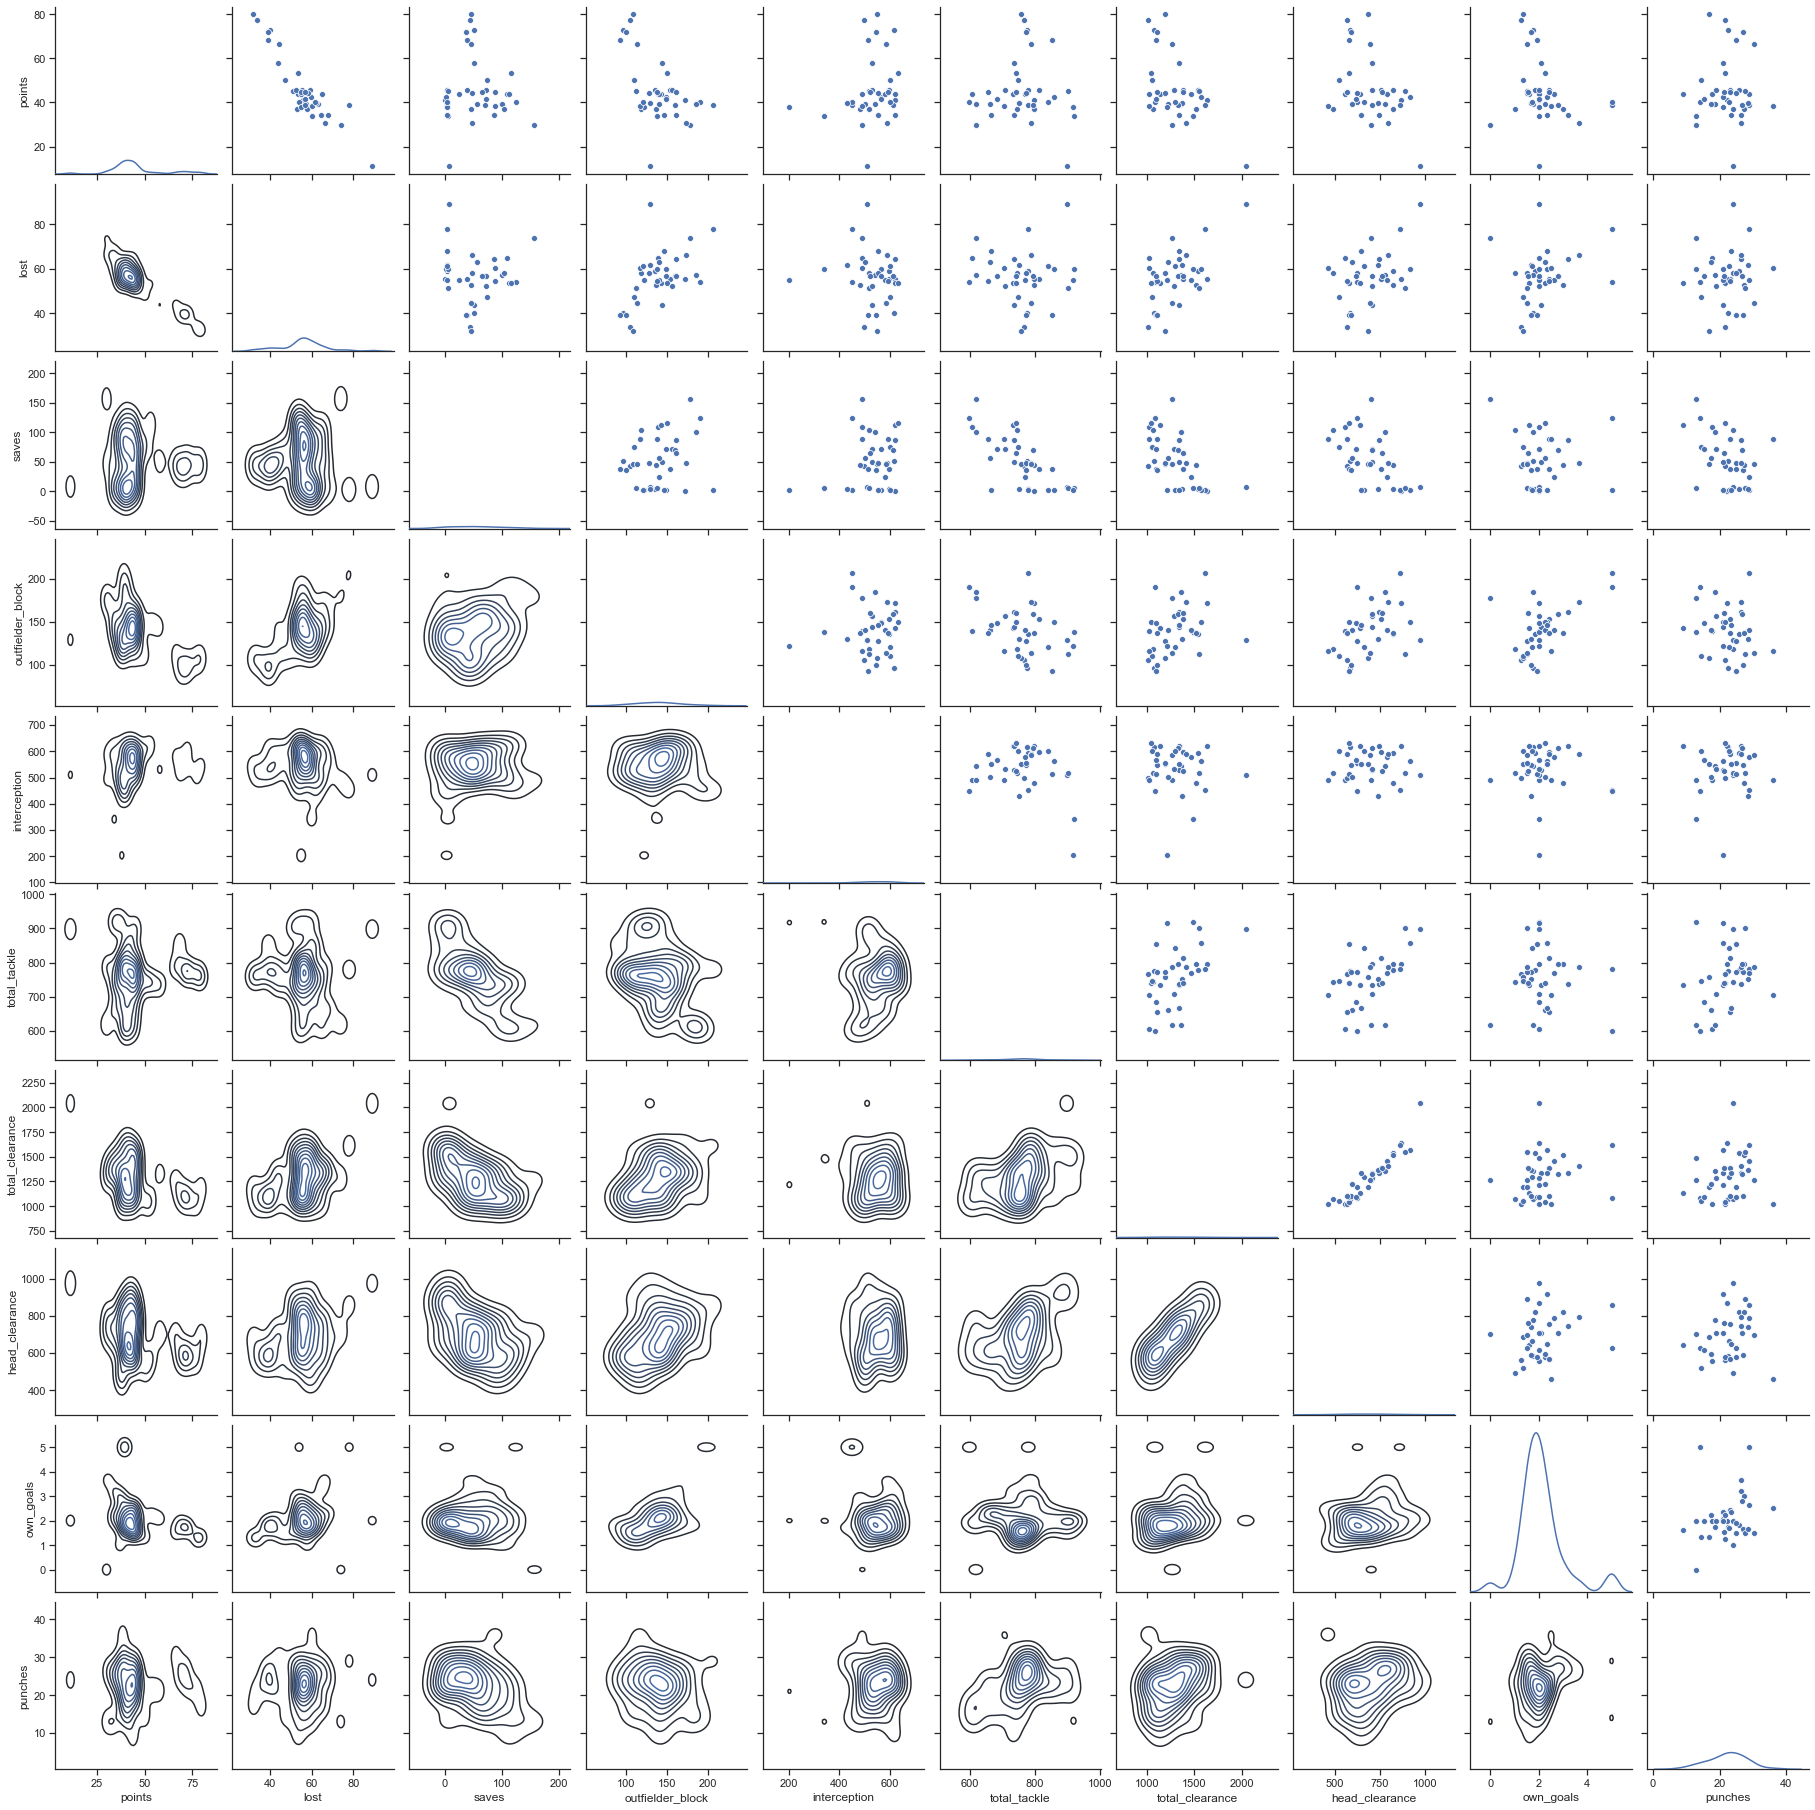

In [27]:
g = sns.PairGrid(average_dfc_team[["points","lost",'saves','outfielder_block', 'interception',
       'total_tackle', 'total_clearance', 'head_clearance',
       'own_goals','punches']])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

### It seem the relations between defence variables and lost are not as strong as that between offence and goals. But some interesting suggestions are still shown us in this figure.

>Head cleanrance and cleanrance have strong relationship. Considering high guards are commonly good at head cleanrance, their shortage in tackle and groud interception are not significantly presented in this figure.

>Big 7 have better defence efficency since when medium level team have same performance in defence with big 7, big 7 tend to lost less and make more points. That may come from a result of more possession time of balls.

>Acutally most teams have similar chance of making own goals, so it comes from bad luck rather than rigging of games under the hood.

### 2.2.4.c Pass and Control
>In order to see if ball possession and passes have obvious influence on the matches, we are obliged to begin with the similar procedure as above.

In [28]:
ctr_stats_season = stats_seasons[["team","season","points","goals","lost",'total_pass',
                                  'total_long_balls', 'backward_pass','total_cross', ]]
average_ctr_team = ctr_stats_season.groupby(["team"]).mean()
average_ctr_team.head(5)

,points,goals,lost,total_pass,total_long_balls,backward_pass,total_cross
team,,,,,,,
AFC Bournemouth,44.000000,48.333333,65.000000,16851.000000,2414.666667,2483.000000,694.666667
Arsenal,72.666667,71.750000,40.083333,20473.750000,1844.500000,2873.125000,855.833333
Aston Villa,45.600000,44.900000,55.400000,13794.500000,2179.200000,2204.166667,876.200000
Birmingham City,41.333333,40.333333,55.666667,12735.333333,2436.333333,2221.000000,764.666667
Blackburn Rovers,45.833333,46.166667,59.000000,12752.166667,2243.166667,1746.000000,807.000000


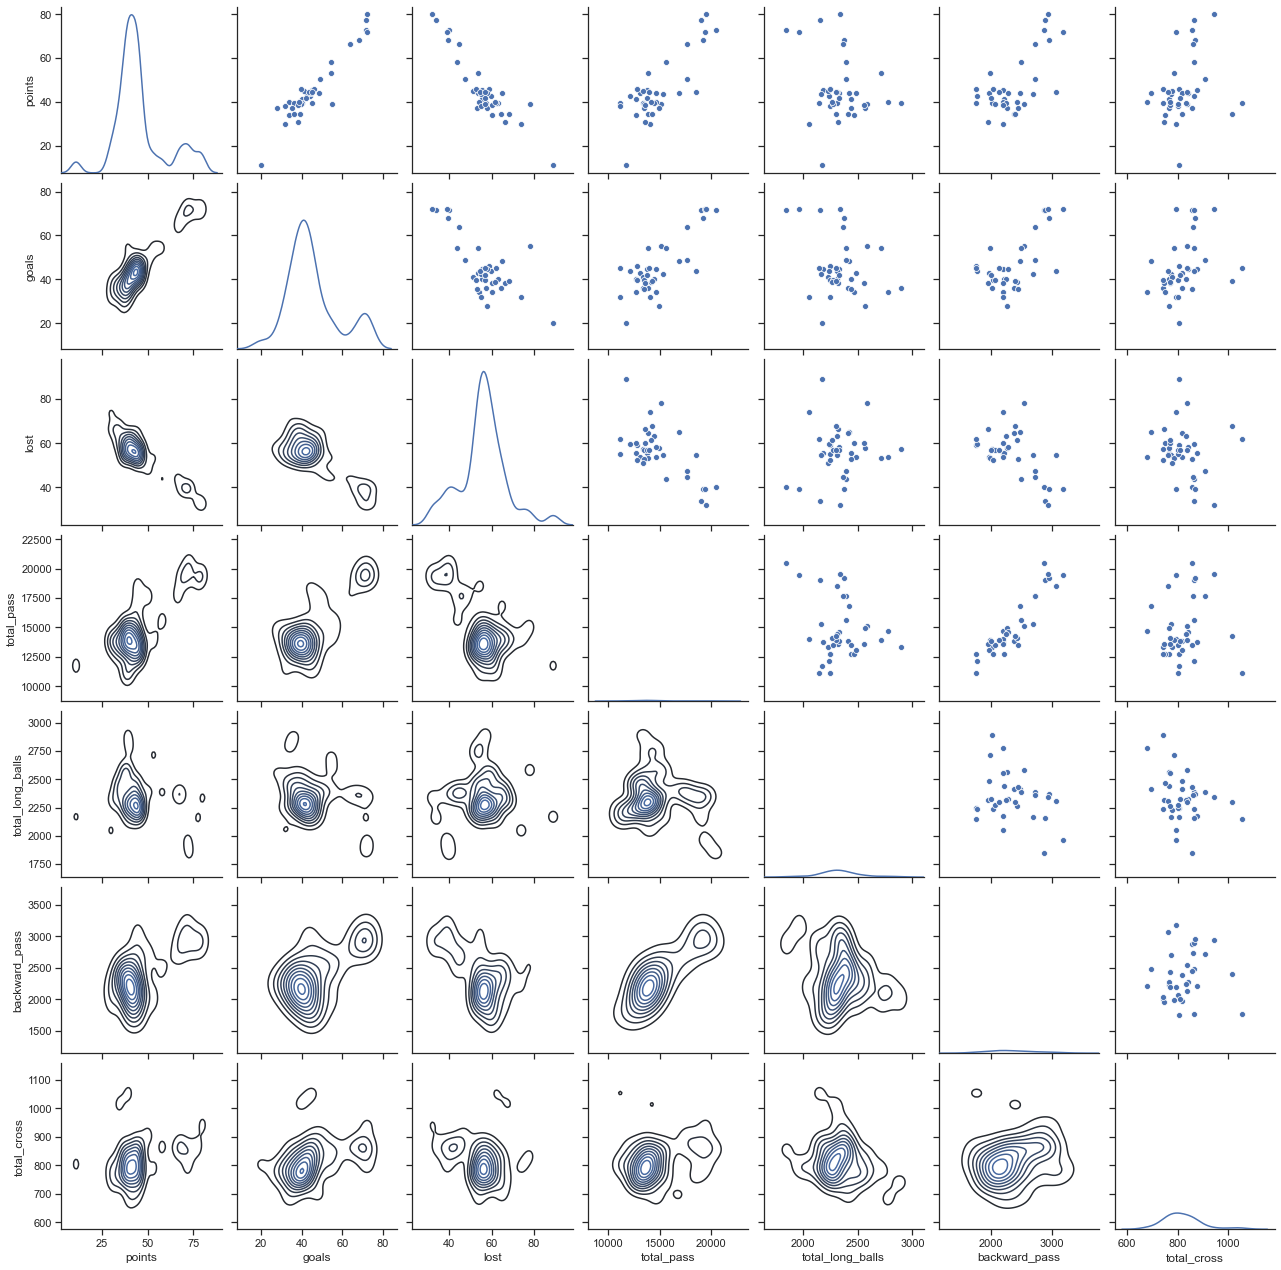

In [29]:
g = sns.PairGrid(average_ctr_team)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

### It is easy to notice that passes have influence on the match.

> Total pass fits points and goals good. It means more passes lead to higher chance of win in a whole.

>But total long pass has no significant relation with points, goal or lost. That means the rest pass, namely short pass, is the main contributor to points.

>Besides of foward pass, big 7 also make more backward pass which reflects that backwards pass benefits goals and points. It possibly suggests that when you want to goal, do not always attack, use some backpass may help to create better chance in attack. 

### 2.2.4.d Correlation of total attributes

>Now that we have checked the relationships and distributions among offence, defence and pass, it is perfect fair to compute the correlation between each pair of all. 

>We will do it and visualize by using heatmap.

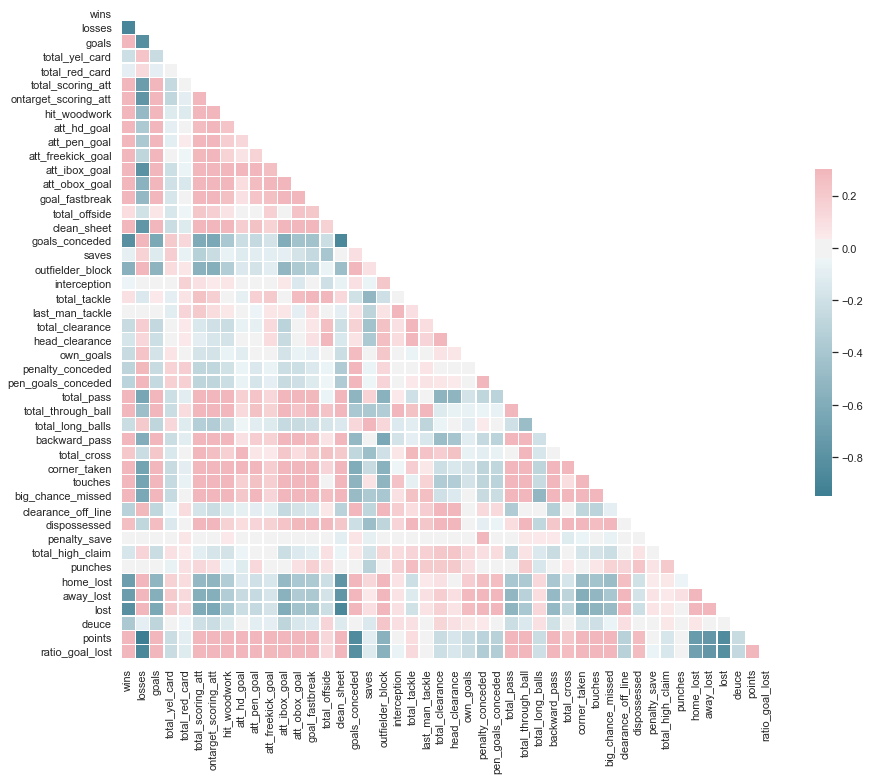

In [30]:
sns.set(style = "white")

corr = stats_seasons.corr()

mask = np.triu(np.ones_like(corr, dtype = np.bool))

f, ax = plt.subplots(figsize = (15, 12))

cmap = sns.diverging_palette(220, 10, as_cmap = True) 

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

### Apart from those direct indicators, some relations between offence and defence attributes illuminate us. 

>Backward Pass has a reletively strong negative correlation with outfield block. Possibly better Backward Pass can eliminate the rivals' chance to control the ball on your side.

>Total tackle has a reletively strong negative correlation with saves. Maybe heavy pressure by continuous tackles on the ball and controller will reduces their chance to make shot.

>Total number of shot has a wide relatively strong negative correlation with many defence attributes such as block, save and clearance. It provides a possible hypothesis that good offence will reduce the pressure on defence. It is also reasonable pragmatically that more offence needs more control of ball, it reduce the time and chance of rivals to make attacks. So, keep shooting like C.Ronaldo.

### 3. Summary:
>1, The Best Seven in Premier League have the leading positions among any detailed attributes. The well-around capabilities make them stronger and better performing than others. In other word, they do not have obvious shortage which can be taken advantage in games.

>2, Home game is easier than away, if teams lose their advantage in home games, commonly they don't have a better chance to make an reverse in the away game.

>3, Statistics show that attacking variables have a better relationship with points in table than defence. So, if medium teams want to make a further step, it's a good start to improve offence as well as the whole performance.

>4, Adopting more short-pass instead of long-pass gives teams more chance to goal. In addition, backward-pass also contributes to goals significantly. So, in a word, try to control the ball if the team want a winning game.

>5, A good balance between offence and defence is the key to better rank in table, as ratio of goal to lost has the most strong relation to points among all these variables.

>6, If teams play bad in offence, it is highly possible that they also suffer in defence, vice versa.

In [31]:
from IPython.display import Image

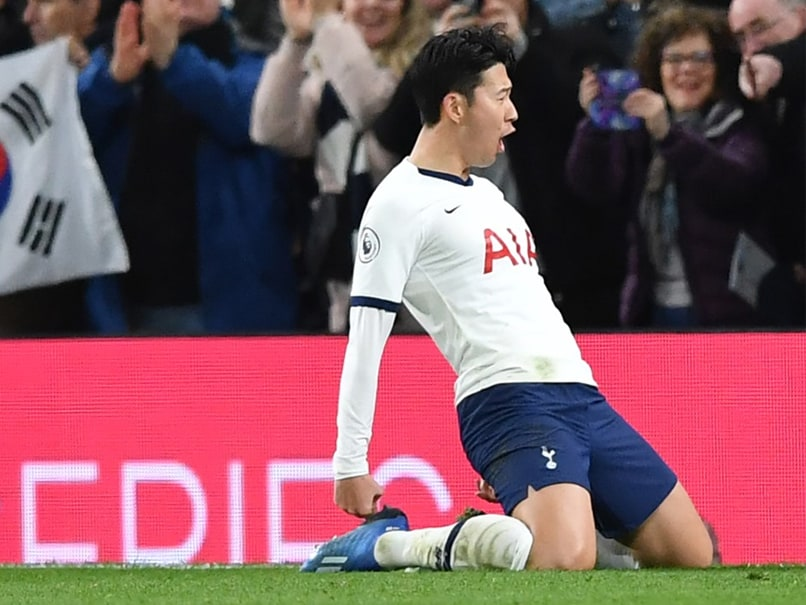

In [32]:
Image("https://c.ndtvimg.com/2020-04/c6jopkh8_son-heungmin-afp_625x300_06_April_20.jpg")

# Thanks for Reading!

### REFERNCES

1.Lee, A. J. (1997). Modeling scores in the Premier League: is Manchester United really the best?. Chance, 10(1), 15-19.

2.Dellal, A., Chamari, K., Wong, D. P., Ahmaidi, S., Keller, D., Barros, R., ... & Carling, C. (2011). Comparison of physical and technical performance in European soccer match-play: FA Premier League and La Liga. European Journal of Sport Science, 11(1), 51-59.

### APPENDIX

1.https://www.soccerbase.com/teams/team.sd?team_id=1563&teamTabs=managers

2.https://www.kaggle.com/zaeemnalla/premier-league

In [29]:
exit()